In [49]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re
import glob
%matplotlib inline

Got the idea and base for this code from https://github.com/davidmantillanyc/ghettotcx/blob/master/ghettotcx/tcx.py

 ghettotcx.py

 MIT License
 
 Copyright (c) 2016 David Mantilla
 
 Permission is hereby granted, free of charge, to any person obtaining a copy
 of this software and associated documentation files (the "Software"), to deal
 in the Software without restriction, including without limitation the rights
 to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
 copies of the Software, and to permit persons to whom the Software is
 furnished to do so, subject to the following conditions:
 
 The above copyright notice and this permission notice shall be included in all
 copies or substantial portions of the Software.

In [50]:
from xml.etree.ElementTree import iterparse

In [51]:
relevant_tags = ['{http://www.garmin.com/xmlschemas/TrainingCenterDatabase/v2}Trackpoint',
                 '{http://www.garmin.com/xmlschemas/TrainingCenterDatabase/v2}Time',
                 '{http://www.garmin.com/xmlschemas/TrainingCenterDatabase/v2}DistanceMeters',
                 '{http://www.garmin.com/xmlschemas/TrainingCenterDatabase/v2}Cadence',
                 '{http://www.garmin.com/xmlschemas/ActivityExtension/v2}Speed',
                 '{http://www.garmin.com/xmlschemas/ActivityExtension/v2}Watts',
                 '{http://www.garmin.com/xmlschemas/TrainingCenterDatabase/v2}UnitId']

In [52]:
time_list = []
dist_list = []
cadence_list = []
speed_list = []
watt_list = []

filename = 'wattbike_raw_files/wattbike_20190223T083000.tcx'
items = iterparse(filename, events=['start'])
counter = 0
for (event, node) in items:
    if node.tag not in relevant_tags:
        # Ignore irrelevant information
        continue
    if node.tag:
        if node.tag.strip() == '{http://www.garmin.com/xmlschemas/TrainingCenterDatabase/v2}Time':
            counter += 1
            timevalue = node.text.strip() if node.text else np.nan
            time_list.append(timevalue)
        elif counter < 1:
            # Avoid asigning any other values before a time has been registered
            continue
        elif node.tag.strip() == '{http://www.garmin.com/xmlschemas/TrainingCenterDatabase/v2}DistanceMeters':
            dist = node.text.strip() if node.text else np.nan
            dist_list.append(dist)
        elif node.tag.strip() == '{http://www.garmin.com/xmlschemas/TrainingCenterDatabase/v2}Cadence':
            cad = node.text.strip() if node.text else np.nan
            cadence_list.append(cad)
        elif node.tag.strip() == '{http://www.garmin.com/xmlschemas/ActivityExtension/v2}Speed':
            speed = node.text.strip() if node.text else np.nan
            speed_list.append(speed)
        elif node.tag.strip() == '{http://www.garmin.com/xmlschemas/ActivityExtension/v2}Watts':
            watt = node.text.strip() if node.text else np.nan
            watt_list.append(watt)
        elif node.tag.strip() == '{http://www.garmin.com/xmlschemas/TrainingCenterDatabase/v2}UnitId':
            bike_id = node.text.strip() if node.text else np.nan
        else:
            pass

In [53]:
df = pd.DataFrame({'distance':dist_list, 'cadence':cadence_list, 'speed':speed_list, 'watts':watt_list},
                  index=pd.to_datetime(time_list))
print df[df.index.isnull()]
print df.info()

Empty DataFrame
Columns: [cadence, distance, speed, watts]
Index: []
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1950 entries, 2019-02-23 08:30:29 to 2019-02-23 09:02:59
Data columns (total 4 columns):
cadence     1950 non-null object
distance    1936 non-null object
speed       1947 non-null object
watts       1950 non-null object
dtypes: object(4)
memory usage: 76.2+ KB
None


In [54]:
# Convert data to floats
df = df.astype(float)

Note that there is a missing time step in the index (NaT). I think the easiest thing is to just remove this row:

In [55]:
df = df[~df.index.isnull()]
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1950 entries, 2019-02-23 08:30:29 to 2019-02-23 09:02:59
Data columns (total 4 columns):
cadence     1950 non-null float64
distance    1936 non-null float64
speed       1947 non-null float64
watts       1950 non-null float64
dtypes: float64(4)
memory usage: 76.2 KB


In [56]:
# Interpolate to fill NaNs
df.interpolate(axis=0, inplace=True, method='time')    # method='time' interpolates with respect to time index
df.head()

,cadence,distance,speed,watts
2019-02-23 08:30:29,75.0,7.69,9.61,167.0
2019-02-23 08:30:30,79.0,15.70,10.54,214.0
2019-02-23 08:30:31,85.0,30.82,10.65,220.0
2019-02-23 08:30:32,86.0,38.20,10.54,214.0
2019-02-23 08:30:33,88.0,45.88,11.30,259.0


In [57]:
# Make new column with seconds from start
df['activity_time'] = (df.index - df.index[0])
df.activity_time = [tstamp.total_seconds() for tstamp in df.activity_time]

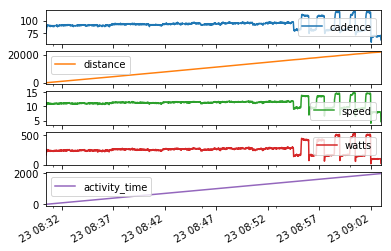

In [58]:
df.plot(subplots=True)
plt.show()

# Combine with HR from corresponding .fit

In [59]:
filedate = re.findall('\d{8}T', filename)[0]
file_HR = glob.glob('tomtom_raw_and_pkl/cycle-' + filedate + '*HR_data.pkl')
print file_HR[0]

tomtom_raw_and_pkl\cycle-20190223T080702-HR_data.pkl


In [60]:
df_hr = pd.read_pickle(file_HR[0])
df_hr.head()

,calories,heart_rate
timestamp,,
2019-02-23 08:06:51,0.0,72
2019-02-23 08:06:52,0.0,77
2019-02-23 08:06:53,0.0,77
2019-02-23 08:06:54,0.0,75
2019-02-23 08:06:55,0.0,78


In [61]:
# Resample HR dataframe to match wattbike dataframe time stamps
old_index = df_hr.index
df_hr_rs = df_hr.reindex(old_index.union(df.index)).interpolate('index').reindex(df.index)
df_hr_rs.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1950 entries, 2019-02-23 08:30:29 to 2019-02-23 09:02:59
Data columns (total 2 columns):
calories      1950 non-null float64
heart_rate    1949 non-null object
dtypes: float64(1), object(1)
memory usage: 45.7+ KB


In [62]:
df_full = df.join(df_hr_rs)
df_full.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1950 entries, 2019-02-23 08:30:29 to 2019-02-23 09:02:59
Data columns (total 7 columns):
cadence          1950 non-null float64
distance         1950 non-null float64
speed            1950 non-null float64
watts            1950 non-null float64
activity_time    1950 non-null float64
calories         1950 non-null float64
heart_rate       1949 non-null object
dtypes: float64(6), object(1)
memory usage: 121.9+ KB


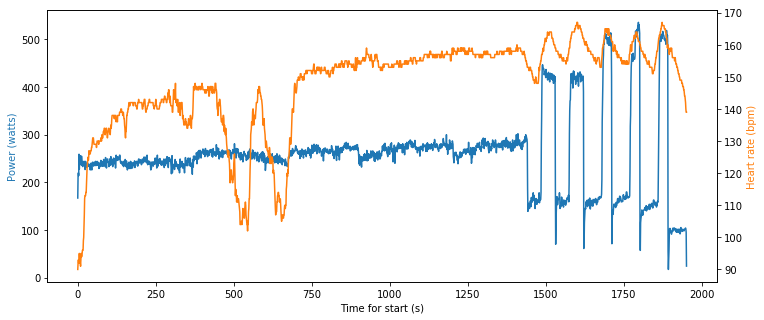

In [63]:
f = plt.figure(figsize=(12,5))
ax = f.add_subplot(111, xlabel='Time for start (s)')
ax2 = ax.twinx()

ax.plot(df_full.activity_time, df_full.watts, 'C0')
ax2.plot(df_full.activity_time, df_full.heart_rate, 'C1')

ax.set_ylabel('Power (watts)', color='C0')
ax2.set_ylabel('Heart rate (bpm)', color='C1')

plt.show()

In [64]:
# Save combined data in pickle file
#prefix = file_HR[0].split('HR')[0]
prefix = re.findall('cycle-\d{8}T\d{6}-', file_HR[0])[0]
print prefix
df_full.to_pickle('Processed_dataframes/' + prefix + 'full_data_bikeID' + bike_id + '.pkl')

cycle-20190223T080702-
